In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
import zipfile as zip
import tempfile
import cdsapi

In [2]:
import ipywidgets as widgets
from IPython.display import display
w = widgets.Dropdown(
    options=['red_mullet', 'bluefin_tuna', 'hake'],
    value='red_mullet',
    # rows=10,
    description='Species:',
    disabled=False
)
print('Select the fish species you wish to plot below.')
display(w)

Select the fish species you wish to plot below.


Dropdown(description='Species:', options=('red_mullet', 'bluefin_tuna', 'hake'), value='red_mullet')

In [11]:
fishname = w.value
zipname = 'SS_DBEM_POLCOMS_fish_abundance-all-rcp85-msy11-' + fishname + '-v0.1.zip'
abdname = 'SS_DBEM_POLCOMS_fish_abundance-abundance-rcp85-msy11-' + fishname + '-v0.1.nc'
ctchname = 'SS_DBEM_POLCOMS_fish_abundance-catch-rcp85-msy11-' + fishname + '-v0.1.nc'
fishname

'bluefin_tuna'

If the CDS was working OK we should be able to download. Note, if the download results in a single file it does not get zipped.

In [12]:
with tempfile.TemporaryDirectory() as tmpdirname:
    #print('created temporary directory', tmpdirname)
    c = cdsapi.Client(url='https://cds-dev.copernicus-climate.eu/api/v2', key='307:95ac04a3-0aed-40a1-96be-4f4bd131d449')

    c.retrieve(
        'sis-fish-abundance',
        {
            'format':'zip',
            'model':'ss_dbem_polcoms',
            'variable':['species_abundance','species_catch'],
            'experiment':'rcp85',
            'maximum_sustainable_yield':'11',
            'species':fishname
        },
        tmpdirname + '/' + zipname)
    with zip.ZipFile(tmpdirname + '/' + zipname) as myzip:
        myzip.extractall(tmpdirname)
    #load abundance data (abd) and catch data (catch) dataset
    abd = nc.Dataset(tmpdirname + '/' + abdname)
    catch = nc.Dataset(tmpdirname + '/' + ctchname)

2019-06-11 12:39:11,853 INFO Sending request to https://cds-dev.copernicus-climate.eu/api/v2/resources/sis-fish-abundance
/local/petwa/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
2019-06-11 12:39:12,069 INFO Request is completed
2019-06-11 12:39:12,069 INFO Downloading http://136.156.132.79/cache-compute-0002/cache/data1/dataset-sis-fish-abundance-cea809d7-09f5-4c29-b782-ea9393f9e64d.zip to /tmp/tmpiy3or2lu/SS_DBEM_POLCOMS_fish_abundance-all-rcp85-msy11-bluefin_tuna-v0.1.zip (1.3M)
2019-06-11 12:39:12,199 INFO Download rate 10M/s
/local/petwa/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:858: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urlli

Pull the files from our store for the moment.

In [5]:
#load abundance data (abd) and catch data (catch) dataset
#abd = nc.Dataset('/tmp/SS_DBEM_POLCOMS_fish_abundance-abundance-rcp85-msy11-bluefin_tuna-v0.1.nc')
#catch = nc.Dataset('/tmp/SS_DBEM_POLCOMS_fish_abundance-catch-rcp85-msy11-bluefin_tuna-v0.1.nc')
#print dataset content
print (abd.variables.keys())
print (catch.variables.keys())

odict_keys(['latitude', 'longitude', 'time', 'abundance'])
odict_keys(['latitude', 'longitude', 'time', 'catch'])


In [6]:
#get dataset variables - note: latitute, longitude and time only need to extracted once
lat = abd.variables['latitude']
lon = abd.variables['longitude']
time = abd.variables['time']
fish_abd = abd.variables['abundance']
fish_catch = catch.variables['catch']

In [7]:
#make a map of distribution (fish_abd) or catch (fish_catch)
fish_y = fish_abd[3,:,:]  # to plot a specific year
fish_m = np.mean(fish_abd[3:13,:,:], axis=0)  # to plot a 10 year average
fish_d = ((np.mean(fish_abd[80:90,:,:], axis=0) - np.mean(fish_abd[3:13,:,:], axis=0))/np.mean(fish_abd[3:13,:,:], axis=0))*100  #to plot percentage change between two decades

LON, LAT = np.meshgrid(lon,lat)
time[80]/365

116.07945205479452

/local/petwa/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/local/petwa/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/local/petwa/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4995: MatplotlibDeprecationWarning: The is_scalar function was deprecated in version 2.1.
  elif masked and is_scalar(masked):


Text(0.5,1,'Mean red_mullet abundance, 2010 - 2019')

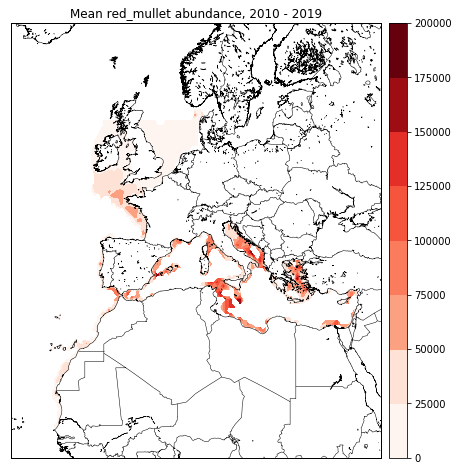

In [8]:
#select area to map numbers provided fit the modelled area
#lower left corner
llLon = -25
llLat = 10
#upper right corner
urLon = 40
urLat = 65
#create map for distribution
plt.figure(figsize=(14, 8))
m = Basemap(projection = 'merc', llcrnrlon = llLon, llcrnrlat = llLat, urcrnrlon = urLon, urcrnrlat = urLat, resolution='h')
m.drawmapboundary(fill_color = 'white')
m.drawlsmask(land_color = "#a5a5a5", ocean_color="white", resolution = 'h')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
m.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
m.contourf(LON,LAT,fish_m, cmap=plt.cm.get_cmap('Reds',10),latlon=True)
m.colorbar() 
plt.title('Mean ' + fishname + ' abundance, 2010 - 2019')

/local/petwa/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/local/petwa/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/local/petwa/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4995: MatplotlibDeprecationWarning: The is_scalar function was deprecated in version 2.1.
  elif masked and is_scalar(masked):


Text(0.5,1,'red_mullet change in abundance')

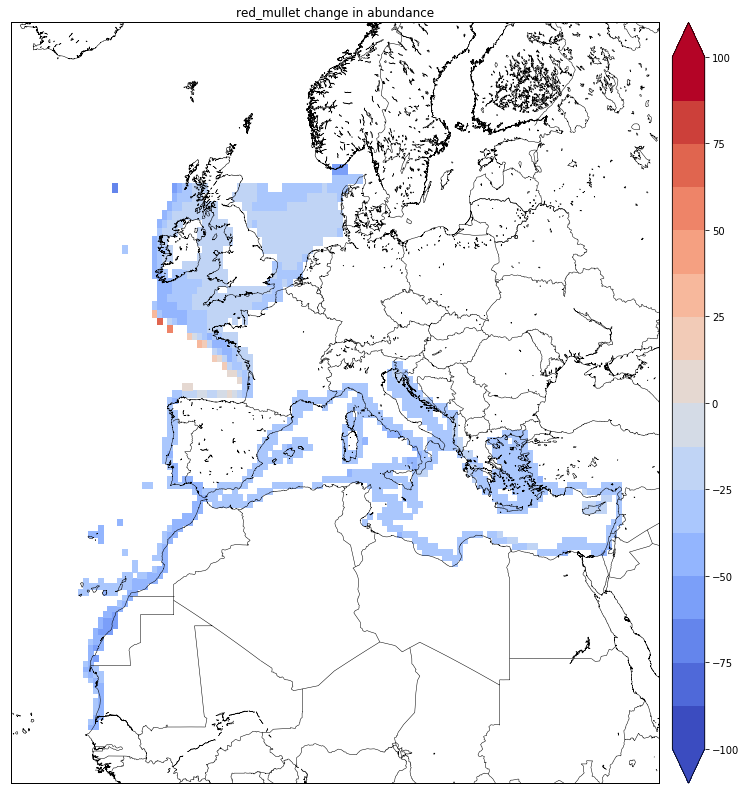

In [9]:
#create map for change
plt.figure(figsize=(14, 14))
m = Basemap(projection = 'merc', llcrnrlon = llLon, llcrnrlat = llLat, urcrnrlon = urLon, urcrnrlat = urLat, resolution='h')
m.drawmapboundary(fill_color = 'white')
m.drawlsmask(land_color = "#a5a5a5", ocean_color="white", resolution = 'h')
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
m.drawcountries(linewidth=0.5, linestyle='solid', color='k', antialiased=1, ax=None, zorder=None)
m.pcolor(LON,LAT,fish_d, cmap=plt.cm.get_cmap('coolwarm',16),latlon=True, vmin=-100, vmax=100)
m.colorbar(extend='both') 
plt.title(fishname + ' change in abundance')


In [10]:
#----------- CREATE TREND PLOT ---------
#select spatial domain
tuna_t = tuna_abd[:,:,:] #full domain
#average spatially
tuna_t = np.mean(tuna_t[:,:,:], axis=(1,2))
#plot the trend
plt.figure()
plt.plot(time,tuna_t,'k',lw='3')
plt.xlabel('Time (years)')
plt.ylabel('Mean Bluefin tuna abundance')
plt.title('Mean Bluefin tuna abundance')

NameError: name 'tuna_abd' is not defined

Text(0.5,1,'Change in Bluefin tuna abundance')

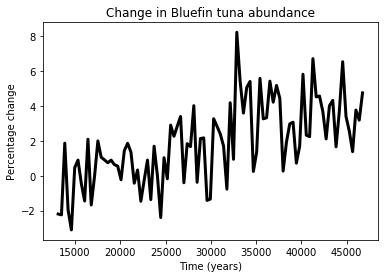

In [52]:
#Calculate %change
tuna_c = ((tuna_t[:]-tuna_t[30])/tuna_t[30])*100
#plot change
plt.figure()
plt.plot(time,tuna_c,'k',lw='3')
plt.xlabel('Time (years)')
plt.ylabel('Percentage change')
plt.title('Change in Bluefin tuna abundance')